In [1]:
import numpy as np
import constants as ct

from planning_utils import create_grid, prune_path

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
def plot_final_grid(grid, path, pruned_path, start, goal, policy):
    fig = plt.figure(figsize=(20, 20))

    plt.imshow(grid, cmap='Greys', origin='lower', extent=[0, grid.shape[0], -0.5, grid.shape[1] - 0.5])

    for row in range(policy.shape[0]):
        for col in range(policy.shape[1]):
            marker = "."
            if policy[row][col] == (1, 0):
                marker = 6
            elif policy[row][col] == (-1, 0):
                marker = 7
            elif policy[row][col] == (0, -1):
                marker = 8
            elif policy[row][col] == (0, 1):
                marker = 9
            plt.scatter(col, row, c='green', s=100, marker=marker)
    
    for idx in range(len(pruned_path) - 1):
       plt.plot([pruned_path[idx][1], pruned_path[idx + 1][1]], [pruned_path[idx][0], pruned_path[idx + 1][0]], 'black' , alpha=0.5, linewidth=10)

    for point in path:
       plt.scatter(point[1], point[0], c='yellow', s=200, alpha=0.5)

    for point in pruned_path:
       plt.scatter(point[1], point[0], c='red', s=400, alpha=0.5)
    
    plt.scatter(start[1], start[0], c='blue', s=400, alpha=0.5)
    plt.scatter(goal[1], goal[0], c='blue', s=400, alpha=0.5)
    
    plt.xlabel('NORTH')
    plt.ylabel('EAST')

    plt.show()


In [3]:
# TARGET_ALTITUDE = 5
# SAFETY_DISTANCE = 5
# source = (10, 700)
# target = (800, 150)
# terminal_states = [target]
# delta = 10

# # Read in obstacle map
# data = np.loadtxt(ct.COLLIDERS_FILE, delimiter=',', dtype='Float64', skiprows=2)
# grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)

# grid

In [4]:
grid = np.full((10, 10), 0) # empty grid
source = (2, 2)
target = (8, 8)
grid[0 : 6, 4 : 6] = 1 # mark obstacles with 1
grid

array([[0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [5]:
# (0, 1) -> next col, (0, -1) -> prev col, (-1, 0) -> prev row, (1, 0) -> next row
possible_actions = [(0, 1), (0, -1), (-1, 0), (1, 0)]

states = list() # all states in the grid
for row in range(grid.shape[0]):
    for col in range(grid.shape[1]):
        states.append((row, col))

def A(state): # state -> actions
    '''
    Given a state, return all actions possible in that state
    '''
    actions = []
    for action in possible_actions:
        new_state = (state[0] + action[0], state[1] + action[1])
        if 0 <= new_state[0] < grid.shape[0] and 0 <= new_state[1] < grid.shape[1]:
            actions.append(action)
    return actions

def T(state, action): # state, action -> [(prob, new_state)]
    '''
    Given a state and an action return the probability of transisioning to the next state from
    current state given on taking given action 
    '''
    return [ \
        (0.8 if valid_action == action else 0.2 / 3.0, \
         (state[0] + valid_action[0], state[1] + valid_action[1]) \
        ) for valid_action in A(state)]

def R(state, action): # state, action -> reward
    '''
    Given a state, action (and next state), return the reward for the transition 
    '''
    next_state = (state[0] + action[0], state[1] + action[1])
    reward = -1 # reward (penalty) for taking any action
    if grid[next_state] == 1: # reward (penalty) for crashing into an obstacle
        reward += -10000
    elif next_state == target: # reward for reaching the target state
        reward += 100
    return reward
        

In [6]:
discount, epsilon = 0.9, 0.001
def value_iteration():
    '''
    Given an MDP, calculate the expected utilities for each state iteratively,
    until they start converging
    '''
    U = np.zeros(grid.shape)
    itr = 0
    while True:
#         print(U)
#         input()
        itr += 1
        U_prev = U.copy()
        delta = 0.0
        
        for state in states: # calculate utility for each state
            actions = A(state)
            max_util = float('-inf')
            for action in actions: # get the maximum utility for each action on the given state
                util = 0
                for transition in T(state, action): # get the utility for a given action on this state + the utility of the next state
                    util += transition[0] * (R(state, action) + discount * U_prev[transition[1]])
                max_util = max(max_util, util)
            U[state] = max_util
                
                
        # stop if the we don't get an improvement in utilities by at least a factor of discount
        delta = 0
        for state in states:
            delta = max(delta, abs(U[state] - U_prev[state]))
        threshold = epsilon * (1 - discount) / discount
        print("Iteration {itr}: Maximum Change - {delta}, Threshold - {threshold}".format(\
                                                        itr=itr, delta=delta, threshold=threshold))
        if delta < threshold:
            return U


In [7]:
final_utilities = value_iteration()

Iteration 1: Maximum Change - 99.0, Threshold - 0.00011111111111111109
Iteration 2: Maximum Change - 88.308, Threshold - 0.00011111111111111109
Iteration 3: Maximum Change - 77.08008000000002, Threshold - 0.00011111111111111109
Iteration 4: Maximum Change - 68.82392160000005, Threshold - 0.00011111111111111109
Iteration 5: Maximum Change - 61.33770892800001, Threshold - 0.00011111111111111109
Iteration 6: Maximum Change - 54.794604384000024, Threshold - 0.00011111111111111109
Iteration 7: Maximum Change - 48.925684222848076, Threshold - 0.00011111111111111109
Iteration 8: Maximum Change - 43.99695950700905, Threshold - 0.00011111111111111109
Iteration 9: Maximum Change - 39.43752414514731, Threshold - 0.00011111111111111109
Iteration 10: Maximum Change - 35.29049184487005, Threshold - 0.00011111111111111109
Iteration 11: Maximum Change - 31.663288947841693, Threshold - 0.00011111111111111109
Iteration 12: Maximum Change - 28.47377165071447, Threshold - 0.00011111111111111109
Iteration 

In [8]:
final_utilities

array([[ 42.07281393,  55.01276848,  64.65571088,  70.63716102,
         60.52481473,  96.70449512, 120.10677185, 136.42622464,
        141.20904413, 110.74127679],
       [ 55.05376902,  68.8089963 ,  80.625066  ,  88.97187595,
         79.95202603, 125.49239983, 148.68369599, 169.00096271,
        176.82267573, 143.2437105 ],
       [ 65.33905278,  81.06597098,  94.83189742, 105.69308303,
         95.5222826 , 147.34577488, 173.34413849, 197.61806387,
        209.18825084, 170.33733079],
       [ 76.69433253,  94.89898451, 110.81784615, 124.90779759,
        113.08989631, 171.28677944, 201.0073409 , 229.89743503,
        246.52995235, 201.00971225],
       [ 89.6690274 , 110.74193479, 129.08280494, 147.40520428,
        135.79721014, 198.92254591, 232.68851472, 266.92793425,
        290.45043901, 237.0206532 ],
       [104.44178037, 128.80546837, 149.92347897, 173.63615033,
        199.07859252, 232.69778227, 268.99589516, 309.36922218,
        342.25239683, 279.48614684],
       [12

In [9]:
policy = {}

def expected_utility(state, action):
    '''
    For a state and an action, return the utility of taking the action on the state
    '''
    utils_per_state = []
    for prob, new_state in T(state, action):
        utils_per_state.append(prob * (R(state, action) + discount * final_utilities[new_state]))
    return sum(utils_per_state)

for state in states: # from the converged utilities, determine the best policy for each state
    if state == target:
        policy[state] = 'none'
    else: # determine the action that yields the maximum utility for this state
        policy[state] = max((expected_utility(state, action), action) for action in A(state))[1]


policy_grid = np.zeros(grid.shape, dtype=object)
for state in policy:
    policy_grid[state] = policy[state]
policy_grid        

array([[(1, 0), (1, 0), (1, 0), (1, 0), (0, -1), (0, 1), (1, 0), (1, 0),
        (1, 0), (1, 0)],
       [(0, 1), (1, 0), (1, 0), (1, 0), (0, -1), (0, 1), (1, 0), (1, 0),
        (1, 0), (0, -1)],
       [(0, 1), (1, 0), (1, 0), (1, 0), (0, -1), (0, 1), (1, 0), (1, 0),
        (1, 0), (0, -1)],
       [(0, 1), (0, 1), (1, 0), (1, 0), (0, -1), (0, 1), (1, 0), (1, 0),
        (1, 0), (0, -1)],
       [(0, 1), (0, 1), (1, 0), (1, 0), (0, -1), (0, 1), (1, 0), (1, 0),
        (1, 0), (0, -1)],
       [(0, 1), (0, 1), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0),
        (1, 0), (0, -1)],
       [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (1, 0), (1, 0),
        (1, 0), (0, -1)],
       [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (1, 0),
        (1, 0), (0, -1)],
       [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1),
        'none', (0, -1)],
       [(0, 1), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0),
        (-1, 0), (-1, 0), (0, -1)]], dtype=o

In [10]:
curr_state = source
path = [curr_state]
while curr_state != target: # trace path from source to target
    action = policy[curr_state]
    curr_state = (curr_state[0] + action[0], curr_state[1] + action[1])
    
    path.append(curr_state)
print('Path: ', path)

pruned_path = prune_path(path, grid) # get the pruned path, after removing unnecessary waypoints
print('Pruned path: ', pruned_path)

Path:  [(2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 6), (7, 7), (8, 7), (8, 8)]
Pruned path:  [(2, 2), (6, 3), (8, 8)]


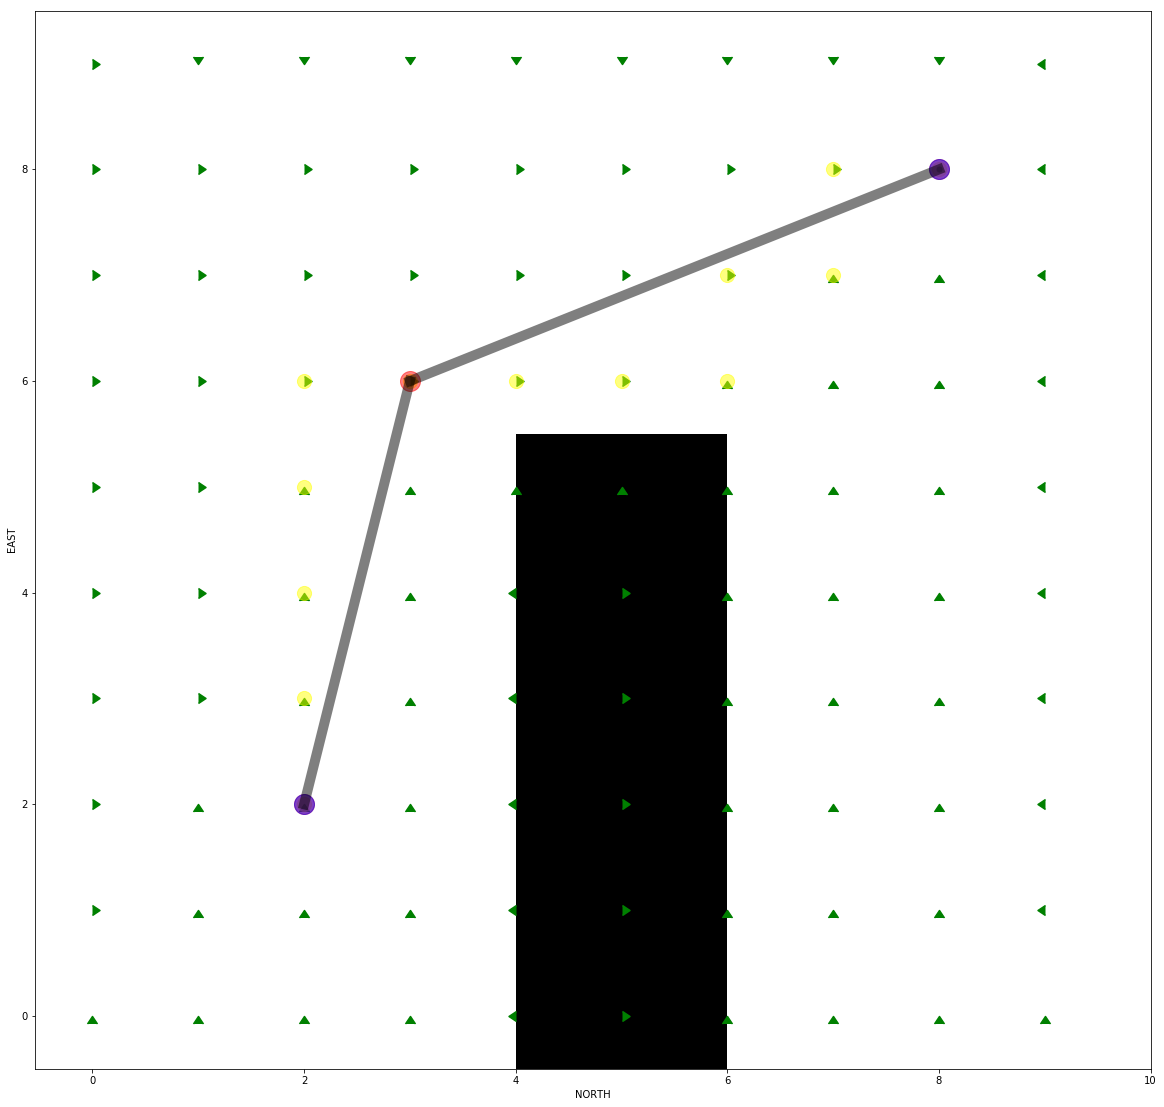

In [11]:
plot_final_grid(grid, path, pruned_path, source, target, policy_grid)